In [1]:
#Script to study the framework residues in the paratope and they difference of this between single domain and full length antibodies
#@author: Henriette Capel
#@Date: 21-04-2022

In [2]:
#Import modules
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from ABDB import database as db
import re
from collections import Counter
%load_ext nb_black

/data/icarus/capel/miniconda3/envs/minor_internship/lib/python3.10/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


<IPython.core.display.Javascript object>

In [3]:
#Constants
dict_cdr_positions = {"CDRH1": [27,38], 
                     "CDRH2": [56,65],
                     "CDRH3": [105,117],
                     "CDRL1": [27,38], 
                     "CDRL2": [56,65],
                     "CDRL3": [105,117]}

<IPython.core.display.Javascript object>

In [4]:
#Functions
def read_dataset(filename_ds):
    
    df = pd.read_csv(filename_ds, converters={i: str for i in range(100)})
    
    for colname in df.columns.values.tolist():
        try:
            df[colname] = [ast.literal_eval(d) for d in df[colname]]
        except:
            pass

    return df


def determine_interacting_framework_residues(df, dict_cdr_positions):
    #This function determines the framework residues for both the heavy and the light chain. For single domain antibodies the light chain is an empty dictionary.
    framework_heavy = []
    framework_light = []
    for index, row in df.iterrows():
        paratope_dict = row['paratope_num_interactions'] #Note: keys stored as aminoacid_position_insertion (not positioninsertion as "paratope_interactions" which was used before filtering on hetero atoms)
        ab_chain = row['antibody_chain']
        is_full_length = (len(ab_chain)==2)
        if is_full_length:
            framework_heavy.extend(store_framework_residues(paratope_dict[ab_chain[0]], dict_cdr_positions, ["CDRH1", "CDRH2", "CDRH3"]))
            framework_light.extend(store_framework_residues(paratope_dict[ab_chain[1]], dict_cdr_positions, ["CDRL1", "CDRL2", "CDRL3"]))
            
        else: #single domain
            framework_heavy.extend(store_framework_residues(paratope_dict, dict_cdr_positions, ["CDRH1", "CDRH2", "CDRH3"]))
    return framework_heavy, framework_light

def store_framework_residues(dict_residues, dict_cdr_positions, cdrs_interested):
    #This function stores the residues that are framework residues. Does this by checking if a certain position does not belong to the CDR
    unique_framework_positions= set()
    
    #Stores the cdr positions 
    list_cdr_positions = []
    for cdr_type in cdrs_interested:
        start = dict_cdr_positions[cdr_type][0]
        stop = dict_cdr_positions[cdr_type][1]
        list_cdr_positions.extend(list(range(start,stop+1)))
        
    #Loop over every position, if not a CDR residue, than save the position
    #Note aa_12_B is now stored as aa_12. But if aa_12 and aa_12_B are in the paratope. It is counted as 1. 
    for position in dict_residues.keys():
        res_position = int(position.split("_")[1])
        
        if res_position not in list_cdr_positions:
            unique_framework_positions.add(res_position)
    return unique_framework_positions

def count_occurence_framework_residues(list_framework_res):
    return dict(Counter(list_framework_res))

def plot_occurence_framework_residues(list_framework_res_1, color, title):
    dict_occurence_1 = count_occurence_framework_residues(list_framework_res_1)
    fig, ax = plt.subplots()
    
    #Make fraction of occurence
    dict_occurence_1_fraction = {k: v / total for total in (sum(dict_occurence_1.values()),) for k, v in dict_occurence_1.items()}
    x_1 = dict_occurence_1_fraction.keys()
    y_1 = dict_occurence_1_fraction.values()
    
    ax.bar(x_1, y_1, color = color)
    ax.set_xlim([0, max(dict_occurence_1.keys())+1])
    
    plt.xlabel("Framework IMGT positions")
    plt.ylabel("Fraction over all observed framework residues in dataset")
    
    plt.title(f"{title}")
    plt.show()
    return None
    
def plot_occurence_framework_residues_2sets(list_framework_res_1, list_framework_res_2, color1, color2, label1, label2, title, threshold = False):
    dict_occurence_1 = count_occurence_framework_residues(list_framework_res_1)
    dict_occurence_2 = count_occurence_framework_residues(list_framework_res_2)
    
    fig, ax = plt.subplots()

    #Make fraction of occurence
    dict_occurence_1_fraction = {k: v / total for total in (sum(dict_occurence_1.values()),) for k, v in dict_occurence_1.items()}
    dict_occurence_2_fraction = {k: v / total for total in (sum(dict_occurence_2.values()),) for k, v in dict_occurence_2.items()}
    
    #add constant to keys of dictionary_2 such that can plot next to each other
    constant = 0.4
    dict_occurence_2_fraction = {k+constant: v for k,v in dict_occurence_2_fraction.items()}
        
    if threshold:
        dict_occurence_1_fraction = {key:val for key, val in dict_occurence_1_fraction.items() if val > threshold}
        dict_occurence_2_fraction = {key:val for key, val in dict_occurence_2_fraction.items() if val > threshold}
    
    #Determine x limit
    max_1 = max(dict_occurence_1_fraction.keys())
    max_2 = max(dict_occurence_2_fraction.keys())
    max_value = max([max_1, max_2])
    
    min_1 = min(dict_occurence_1_fraction.keys())
    min_2 = min(dict_occurence_2_fraction.keys())
    min_value = min([min_1, min_2])
    
    #Input data
    x_1 = dict_occurence_1_fraction.keys()
    y_1 = dict_occurence_1_fraction.values()
    x_2 = dict_occurence_2_fraction.keys()
    y_2 = dict_occurence_2_fraction.values()
    
    ax.bar(x_1, y_1, width = 0.4, color = color1, label = label1)
    ax.bar(x_2, y_2, width= 0.4, color = color2, label = label2)
    ax.set_xlim([min_value-1, max_value+1])
    
    plt.xlabel("Framework IMGT positions")
    plt.ylabel("Fraction over all observed framework residues in dataset")
    plt.legend()
    plt.title(f"{title}")
    plt.show()
    
    return None
    
def create_dataframe_framework_residues(list_framework_residues, df_arp):
    #This function determines the occurence of a certain framework residue in the paratope. 
    #It divides how often a certain position is seen by the number of complexes in the dataset
    dict_framework = count_occurence_framework_residues(list_framework_residues)
    df_framework_info = pd.DataFrame(dict(sorted(dict_framework.items())), index = [0]).T
    
    df_framework_info.columns = ["occurence"]
    df_framework_info["fraction_occurence"] = df_framework_info["occurence"] / df_arp.shape[0]
    
    return df_framework_info

def combine_df_info(df_info_nb, df_info_fv):
    #This function combines the occurence information of the single domain and full length antibody dataset and saves it in one dataframe.
    #The dataframe is sorted on the highest occurence in the single domain dataset
    
    df_info_nb.columns = ["occurence_sd", "fraction_occurence_sd"]
    df_info_fv.columns = ["occurence_fl", "fraction_occurence_fl"]
    df_combined = pd.concat([df_info_nb, df_info_fv], axis = 1)
    df_combined = df_combined.sort_values(by='fraction_occurence_sd', ascending=False)
    df_combined["position"]=df_combined.index
    return df_combined

<IPython.core.display.Javascript object>

In [5]:
##Load data
#Note use the paratope information after filtering on the hetero atoms
#Single domain antibodies
ds_name_arp_nb = "Dataset_nb_arpeggio_interactions.csv"
df_arp_nb = read_dataset(ds_name_arp_nb)

ds_name_arp_fv = "Dataset_fv_arpeggio_interactions.csv"
df_arp_fv = read_dataset(ds_name_arp_fv)

<IPython.core.display.Javascript object>

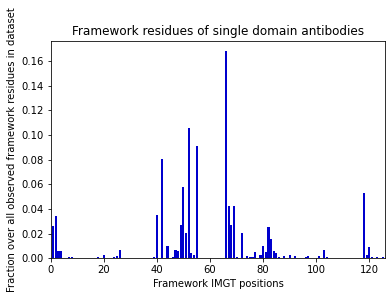

<IPython.core.display.Javascript object>

In [6]:
#Single domain antibodoes
heavy_framework_nb, light_framework_nb = determine_interacting_framework_residues(df_arp_nb, dict_cdr_positions)
dict_heavy_framework_nb = count_occurence_framework_residues(heavy_framework_nb)
plot_occurence_framework_residues(heavy_framework_nb, "mediumblue", "Framework residues of single domain antibodies")

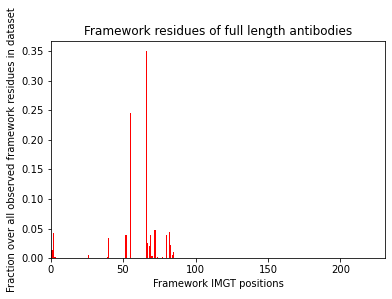

<IPython.core.display.Javascript object>

In [7]:
#full length antibodies
heavy_framework_fv, light_framework_fv = determine_interacting_framework_residues(df_arp_fv, dict_cdr_positions)
dict_heavy_framework_fv = count_occurence_framework_residues(heavy_framework_fv)
plot_occurence_framework_residues(heavy_framework_fv, "red", "Framework residues of full length antibodies")

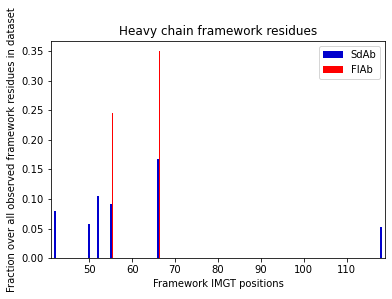

<IPython.core.display.Javascript object>

In [8]:
#Plot both SdAbs and FlAbs in one
plot_occurence_framework_residues_2sets(heavy_framework_nb, heavy_framework_fv, "mediumblue", "red", "SdAb", "FlAb", "Heavy chain framework residues", threshold =0.05)

In [9]:
#Compare values in a dataframe
df_heavy_nb = create_dataframe_framework_residues(heavy_framework_nb, df_arp_nb)
df_heavy_fv = create_dataframe_framework_residues(heavy_framework_fv, df_arp_fv)
df_heavy_combined = combine_df_info(df_heavy_nb, df_heavy_fv)

<IPython.core.display.Javascript object>

In [10]:
df_heavy_combined

,occurence_sd,fraction_occurence_sd,occurence_fl,fraction_occurence_fl,position
66,174.0,0.504348,433.0,0.486517,66
52,109.0,0.315942,49.0,0.055056,52
55,94.0,0.272464,304.0,0.341573,55
42,83.0,0.240580,NaN,NaN,42
50,60.0,0.173913,NaN,NaN,50
118,55.0,0.159420,1.0,0.001124,118
69,44.0,0.127536,49.0,0.055056,69
67,44.0,0.127536,32.0,0.035955,67
40,36.0,0.104348,43.0,0.048315,40
2,35.0,0.101449,52.0,0.058427,2


<IPython.core.display.Javascript object>

In [11]:
#Check DE loop
df_heavy_combined[(df_heavy_combined["position"]>=80)& (df_heavy_combined["position"]<88)]

,occurence_sd,fraction_occurence_sd,occurence_fl,fraction_occurence_fl,position
82,26.0,0.075362,55.0,0.061798,82
83,16.0,0.046377,27.0,0.030337,83
80,10.0,0.028986,48.0,0.053933,80
84,6.0,0.017391,7.0,0.007865,84
81,5.0,0.014493,1.0,0.001124,81
85,4.0,0.011594,12.0,0.013483,85
86,1.0,0.002899,NaN,NaN,86


<IPython.core.display.Javascript object>

In [12]:
df_heavy_combined.sort_values(by='fraction_occurence_fl', ascending=False)

,occurence_sd,fraction_occurence_sd,occurence_fl,fraction_occurence_fl,position
66,174.0,0.504348,433.0,0.486517,66
55,94.0,0.272464,304.0,0.341573,55
72,21.0,0.060870,58.0,0.065169,72
82,26.0,0.075362,55.0,0.061798,82
2,35.0,0.101449,52.0,0.058427,2
52,109.0,0.315942,49.0,0.055056,52
69,44.0,0.127536,49.0,0.055056,69
80,10.0,0.028986,48.0,0.053933,80
40,36.0,0.104348,43.0,0.048315,40
67,44.0,0.127536,32.0,0.035955,67


<IPython.core.display.Javascript object>

In [13]:
# #Save to file
# df_heavy_combined.to_csv("Dataset_arp_framework_residues.csv", index=False)

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd

In [2]:
fwr_df = pd.read_csv('/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_arp_framework_residues.csv')

In [4]:
fwr_df = fwr_df[['position','fraction_occurence_sd','fraction_occurence_fl']]

In [5]:
fwr_df

,position,fraction_occurence_sd,fraction_occurence_fl
0,66,0.504348,0.486517
1,52,0.315942,0.055056
2,55,0.272464,0.341573
3,42,0.240580,NaN
4,50,0.173913,NaN
5,118,0.159420,0.001124
6,69,0.127536,0.055056
7,67,0.127536,0.035955
8,40,0.104348,0.048315
9,2,0.101449,0.058427


In [12]:
# filter those >10% for sdAbs

fwr_df.loc[fwr_df['fraction_occurence_sd'] > 0.1].sort_values(by='fraction_occurence_sd',ascending=False)

,position,fraction_occurence_sd,fraction_occurence_fl
0,66,0.504348,0.486517
1,52,0.315942,0.055056
2,55,0.272464,0.341573
3,42,0.240580,NaN
4,50,0.173913,NaN
5,118,0.159420,0.001124
6,69,0.127536,0.055056
7,67,0.127536,0.035955
8,40,0.104348,0.048315
9,2,0.101449,0.058427


In [13]:
fwr_df.loc[fwr_df['fraction_occurence_fl'] > 0.1].sort_values(by='fraction_occurence_fl',ascending=False)

,position,fraction_occurence_sd,fraction_occurence_fl
0,66,0.504348,0.486517
2,55,0.272464,0.341573
